In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from utils import *

In [26]:
results_folder = './results_data/xsubject_transform_module/RNN'

results_df = []
for model_id in range(1,7+1):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [27]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep_all'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep_subject_order'])

In [28]:
results_df.head()

,Shuffled,Type,Model,Rep_all,F1_score,Subject
0,False,Train,1,1,0.988439,20.612903
1,False,Train,1,2,0.988514,20.612903
2,False,Train,1,3,0.988117,20.612903
3,False,Train,1,4,0.989159,20.612903
4,False,Train,1,5,0.989064,20.612903


In [29]:
train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Val_Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep_all']).\
rename(columns={'F1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep_all']).\
rename(columns={'F1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Train_score    Subject  Test_score    Subject
Shuffled Model                                               
False    1         0.988916  20.612903    0.952283  20.612903
         2         0.988098  20.612903    0.950460  20.612903
         3         0.986756  20.612903    0.944746  20.612903
         4         0.982661  20.612903    0.936426  20.612903
         5         0.957750  20.612903    0.878073  20.612903
         6         0.969593  20.612903    0.918791  20.612903
         7         0.780283  20.612903    0.629012  20.612903
True     1         0.416206  20.612903    0.175261  20.612903
         2         0.419578  20.612903    0.171660  20.612903
         3         0.427440  20.612903    0.169946  20.612903
         4         0.377566  20.612903    0.147936  20.612903
         5         0.342887  20.612903    0.149975  20.612903
         6         0.342291  20.612903    0.144677  20.612903
         7         0.247618  20.612903    0.120174  20.612903

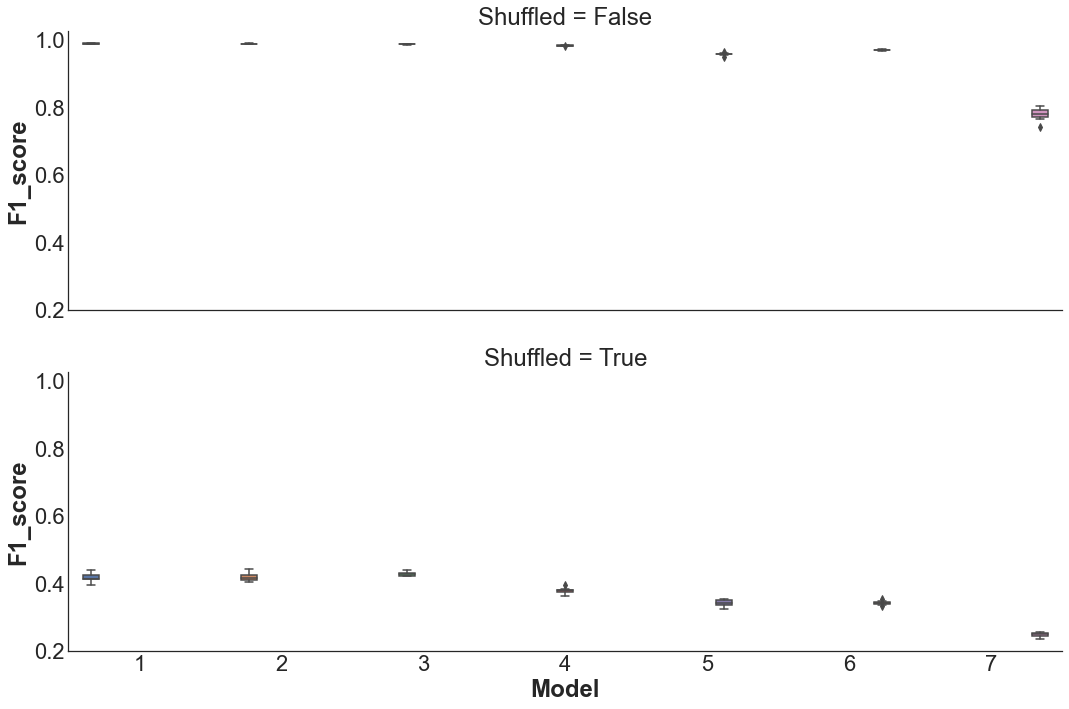

In [30]:
g = sns.catplot(data = train_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3)

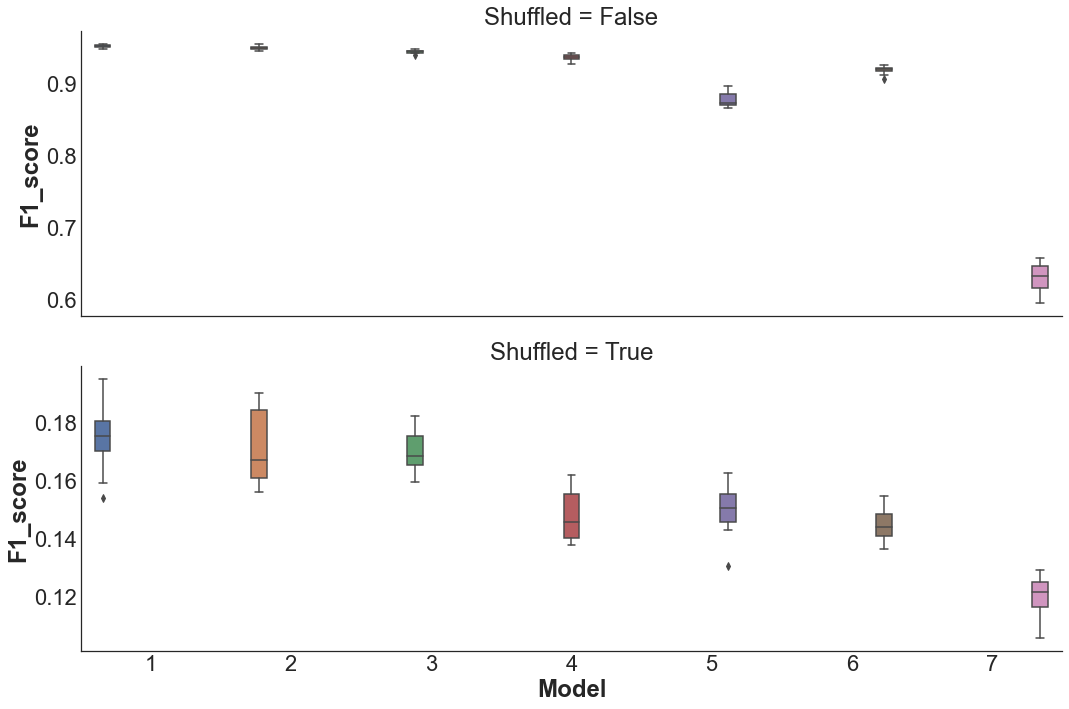

In [31]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

In [18]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [32]:
# Run ANOVA
model = ols('F1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.000221,2.0,36.672144,4.568521e-12
C(Type),0.030151,2.0,5003.279995,1.381354e-85
C(Model):C(Type),0.000127,4.0,10.501161,6.652296e-07
Residual,0.000244,81.0,NaN,NaN


In [33]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
    1 - Train  1 - Val_Test  -0.0366  0.001 -0.0391 -0.0342   True
    1 - Train 1 - Val_Train   0.0001    0.9 -0.0024  0.0026  False
    1 - Train     2 - Train  -0.0008    0.9 -0.0033  0.0017  False
    1 - Train  2 - Val_Test  -0.0385  0.001 -0.0409  -0.036   True
    1 - Train 2 - Val_Train  -0.0011 0.8571 -0.0036  0.0013  False
    1 - Train     3 - Train  -0.0022 0.1363 -0.0046  0.0003  False
    1 - Train  3 - Val_Test  -0.0442  0.001 -0.0466 -0.0417   True
    1 - Train 3 - Val_Train  -0.0015 0.5544  -0.004  0.0009  False
 1 - Val_Test 1 - Val_Train   0.0367  0.001  0.0343  0.0392   True
 1 - Val_Test     2 - Train   0.0358  0.001  0.0333  0.0383   True
 1 - Val_Test  2 - Val_Test  -0.0018 0.3263 -0.0043  0.0007  False
 1 - Val_Test 2 - Val_Train   0.0355  0.001   0.033   0.038   

In [34]:
test_results_true_df = results_df.loc[(results_df.Type == 'Val_Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [35]:
# Run ANOVA
model = ols('F1_score ~ C(Model)', test_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.817145,6.0,1498.798833,5.835319e-66
Residual,0.005725,63.0,NaN,NaN


In [36]:
groups =  test_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(test_results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.0018    0.9 -0.0148  0.0112  False
     1      3  -0.0075 0.5643 -0.0205  0.0054  False
     1      4  -0.0159 0.0074 -0.0288 -0.0029   True
     1      5  -0.0742  0.001 -0.0872 -0.0612   True
     1      6  -0.0335  0.001 -0.0465 -0.0205   True
     1      7  -0.3233  0.001 -0.3363 -0.3103   True
     2      3  -0.0057 0.8091 -0.0187  0.0073  False
     2      4   -0.014 0.0259  -0.027 -0.0011   True
     2      5  -0.0724  0.001 -0.0854 -0.0594   True
     2      6  -0.0317  0.001 -0.0447 -0.0187   True
     2      7  -0.3214  0.001 -0.3344 -0.3085   True
     3      4  -0.0083  0.457 -0.0213  0.0047  False
     3      5  -0.0667  0.001 -0.0797 -0.0537   True
     3      6   -0.026  0.001 -0.0389  -0.013   True
     3      7  -0.3157  0.001 -0.3287 -0.3028   True
     4      5  -0.0584  0.001 -0.0713 -0.0454 

In [ ]:
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Type == 'Test')]